## Setup and Imports:

In [ ]:
%pip install -q diffusers

In [ ]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, DDIMScheduler, UNet2DModel
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


## The Data

Here we're going to test things with a very small dataset: mnist. If you'd like to give the model a slightly harder challenge without changing anything else, torchvision.datasets.FashionMNIST should work as a drop-in replacement.

In [ ]:
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

In [ ]:
#changed batch size to 256 for quicker execution
train_dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([6, 2, 7, 1, 1, 5, 2, 7])


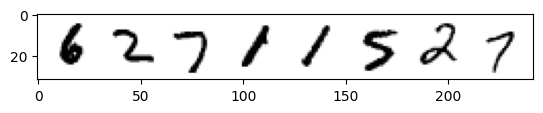

In [ ]:
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

Each image is a greyscale 28px by 28px drawing of a digit, with values ranging from 0 to 1.

## DDPM and DDIM

*   We will use model `UNet2DModel` from `diffuser`.
*   The training objective is by defaultg predicting the noise rather than the denoised image.
*   The model is conditioned on the amount of noise present via timestep conditioning, where t is passed as an additional argument to the forward method.
*   We will explore two sampling strategies: DDPM and DDIM.

### The `UNet2DModel`

*   GroupNorm applies group normalization to the inputs of each block
*   Dropout layers for smoother training
*   Multiple resnet layers per block (if layers_per_block isn't set to 1)
*   Attention (usually used only at lower resolution blocks)
*   Conditioning on the timestep.
*   Downsampling and upsampling blocks with learnable parameters

In [ ]:
model = UNet2DModel(
    sample_size=28,           # the target image resolution
    in_channels=1,            # the number of input channels, 3 for RGB images
    out_channels=1,           # the number of output channels
    layers_per_block=2,       # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64), # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",        # a regular ResNet downsampling block
        "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",          # a regular ResNet upsampling block
      ),
)
print(model)

UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(32, 32, ker

In [ ]:
sum([p.numel() for p in model.parameters()]) # 1.7M

1707009

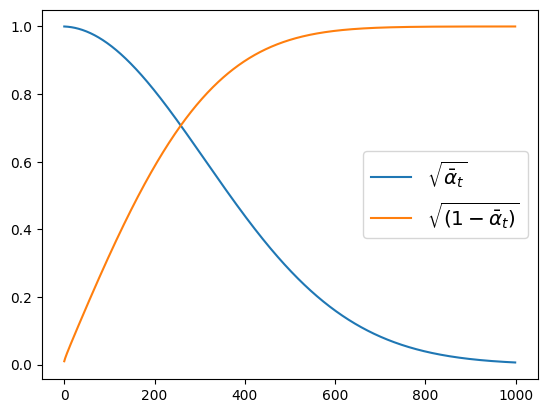

In [ ]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler


scaler = torch.GradScaler()

optimizer = optim.AdamW(model.parameters(),lr=1e-4)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#for plotting training curve
losses = []
steps = []

step_num = 0

print(train_dataloader)

for i in enumerate(train_dataloader):
    i[1][0] = i[1][0].to(device)


    noise_sample = torch.randn_like(i[1][0])

    timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps,(i[1][0].shape[0],),device=device).long()
    
    images_with_added_noise = noise_scheduler.add_noise(i[1][0],noise_sample,timesteps)

    loss = 0

    with autocast():

          predict_noise = model(images_with_added_noise,timesteps).sample
          loss = nn.functional.mse_loss(predict_noise,noise_sample)


    optimizer.zero_grad()

    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()


    if step_num % 50 == 0:
        print("Step: ",step_num," Loss: ", loss.item())

    steps.append(step_num)
    losses.append(loss)

    step_num += 1





#plot training loss curve
plt.plot(steps, [loss.cpu().item() for loss in losses])
plt.xlabel("Step")
plt.ylabel("Training Loss")
plt.title("DDPM Training Loss Curve")
plt.show()

In [ ]:

#generate the 4 sample images

model.eval()
noise_sample = torch.randn((4,1,28,28), device=device)
noise_scheduler.set_timesteps(100)

with torch.no_grad():
    for timestep in noise_scheduler.timesteps:
        predict_noise = model(noise_sample,torch.tensor([timestep]*4,device=device)).sample
        noise = noise_scheduler.step(predict_noise,timestep,noise_sample).prev_sample


plot = plt.subplots(1,4,figsize=(15,8))

for i in range(4):
    plot[1][i].imshow(noise[i].squeeze().cpu().numpy(),cmap="gray")
    plot[1][i].axis("off")
    
plt.show()

DDIM for noise prediction

In [ ]:
#new model to use with DDIM scheduler

model = UNet2DModel(
    sample_size=28,           # the target image resolution
    in_channels=1,            # the number of input channels, 3 for RGB images
    out_channels=1,           # the number of output channels
    layers_per_block=2,       # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64), # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",        # a regular ResNet downsampling block
        "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",          # a regular ResNet upsampling block
      ),
)
print(model)

In [ ]:
noise_scheduler = DDIMScheduler(num_train_timesteps=1000)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler


scaler = torch.GradScaler()

optimizer = optim.AdamW(model.parameters(),lr=1e-4)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#for plotting training curve
losses = []
steps = []

step_num = 0

print(train_dataloader)

for i in enumerate(train_dataloader):
    i[1][0] = i[1][0].to(device)


    noise_sample = torch.randn_like(i[1][0])

    timesteps = torch.randint(0,noise_scheduler.config.num_train_timesteps,(i[1][0].shape[0],),device=device).long()
    
    images_with_added_noise = noise_scheduler.add_noise(i[1][0],noise_sample,timesteps)

    loss = 0

    with autocast():

          predict_noise = model(images_with_added_noise, timesteps).sample
          loss = nn.functional.mse_loss(predict_noise,noise_sample)


    optimizer.zero_grad()

    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()


    if step_num % 50 == 0:
        print("Step: ",step_num," Loss: ", loss.item())

    steps.append(step_num)
    losses.append(loss)

    step_num += 1





#plot training loss curve
plt.plot(steps, [loss.cpu().item() for loss in losses])
plt.xlabel("Step")
plt.ylabel("Training Loss")
plt.title("DDIM Training Loss Curve")
plt.show()

In [ ]:

#generate the 4 sample images

model.eval()
noise_sample = torch.randn((4,1,28,28), device=device)
noise_scheduler.set_timesteps(100)

with torch.no_grad():
    for timestep in noise_scheduler.timesteps:
        predict_noise = model(noise_sample,torch.tensor([timestep]*4,device=device)).sample
        noise = noise_scheduler.step(predict_noise,timestep,noise_sample).prev_sample


plot = plt.subplots(1,4,figsize=(15,8))

for i in range(4):
    plot[1][i].imshow(noise[i].squeeze().cpu().numpy(),cmap="gray")
    plot[1][i].axis("off")
    
plt.show()